## Instalando o pacote

In [ ]:
!pip install Evidently -q
from sklearn import preprocessing

In [ ]:
import pandas as pd
customer_churn = pd.read_csv('https://raw.githubusercontent.com/andresakmr/customer_churn_mlops/refs/heads/main/data/Customer-Churn-Records.csv')

In [ ]:
# 1. Preparação dos dados
X = customer_churn.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited', 'Complain'], axis=1)
y = customer_churn["Exited"]

# 2. Tratamento de variáveis categóricas
X = pd.get_dummies(X, columns=['Geography', 'Gender', 'Card Type'], drop_first=True)

# 3. Escalonamento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 4. Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, random_state=42)

In [ ]:
def check_drift(df_ref, df_cur, column):
    # Compara a coluna do treino com a mesma coluna do teste
    stat, p_value = ks_2samp(df_ref[column], df_cur[column])
    status = "🚨 Drift Detectado" if p_value < 0.05 else "✅ Sem Drift"
    print(f"Coluna: {column:15} | P-Value: {p_value:.4f} | Status: {status}")

print("=== Relatório de Data Drift Completo (Todas as Features) ===\n")

# X_train.columns pega automaticamente todas as 16 colunas do seu DataFrame
for col in X_train.columns:
    check_drift(X_train, X_test, col)

=== Relatório de Data Drift Completo (Todas as Features) ===

Coluna: CreditScore     | P-Value: 0.0853 | Status: ✅ Sem Drift
Coluna: Age             | P-Value: 0.8980 | Status: ✅ Sem Drift
Coluna: Tenure          | P-Value: 0.3432 | Status: ✅ Sem Drift
Coluna: Balance         | P-Value: 0.4652 | Status: ✅ Sem Drift
Coluna: NumOfProducts   | P-Value: 0.5197 | Status: ✅ Sem Drift
Coluna: HasCrCard       | P-Value: 1.0000 | Status: ✅ Sem Drift
Coluna: IsActiveMember  | P-Value: 1.0000 | Status: ✅ Sem Drift
Coluna: EstimatedSalary | P-Value: 0.1224 | Status: ✅ Sem Drift
Coluna: Satisfaction Score | P-Value: 0.9998 | Status: ✅ Sem Drift
Coluna: Point Earned    | P-Value: 0.1499 | Status: ✅ Sem Drift
Coluna: Geography_Germany | P-Value: 1.0000 | Status: ✅ Sem Drift
Coluna: Geography_Spain | P-Value: 0.9974 | Status: ✅ Sem Drift
Coluna: Gender_Male     | P-Value: 1.0000 | Status: ✅ Sem Drift
Coluna: Card Type_GOLD  | P-Value: 1.0000 | Status: ✅ Sem Drift
Coluna: Card Type_PLATINUM | P-Value:

## Criando um cenário de drift

In [ ]:
# 1. Criamos uma cópia dos dados de teste para simular a produção
df_producao = X_test.copy()

# 2. Vamos "estragar" a coluna Age (ex: clientes muito mais velhos)
df_producao['Age'] = df_producao['Age'] + 2.5  # Desloca a média de idade

# 3. Vamos "estragar" a coluna Balance (ex: clientes com muito mais dinheiro)
df_producao['Balance'] = df_producao['Balance'] * 1.8

print("=== Relatório de Data Drift (Simulando Mudança de Comportamento) ===\n")

# 4. Comparamos o X_train (original) com o df_producao (alterado)
for col in ['Age', 'CreditScore', 'Balance']:
    check_drift(X_train, df_producao, col)

=== Relatório de Data Drift (Simulando Mudança de Comportamento) ===

Coluna: Age             | P-Value: 0.0000 | Status: 🚨 Drift Detectado
Coluna: CreditScore     | P-Value: 0.0853 | Status: ✅ Sem Drift
Coluna: Balance         | P-Value: 0.0000 | Status: 🚨 Drift Detectado


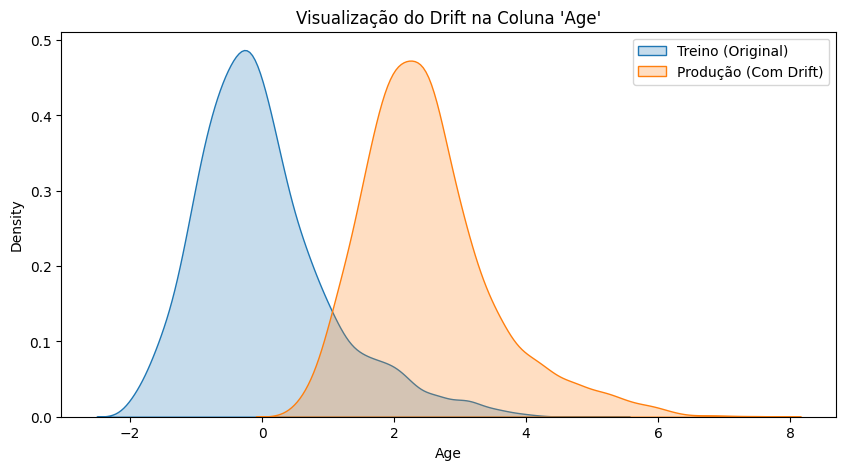

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(X_train['Age'], label='Treino (Original)', fill=True)
sns.kdeplot(df_producao['Age'], label='Produção (Com Drift)', fill=True)
plt.title("Visualização do Drift na Coluna 'Age'")
plt.legend()
plt.show()